In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
import csv
import scipy.stats as stats
plt.style.use('fivethirtyeight')

## Task

Your task in this assignment is to predict the ethnicity of someone's DNA, based on single nucleotide polymorphism data we've shared with you.

## Data values

Each input vector represents the DNA at specific locations in the genome for one individual. There are 20 binary input features. 0 indicates that the user's DNA at the given location matches the human reference genome. 1 indicates that the user's DNA does not match the human reference genome. The output class value represents the super population (ethnicity) of each individual. The super populations contained in this dataset are East Asian or Mixed American, encoded in binary. The training data set contains 283 data vectors, and the testing data set contains 184 data vectors.

We will do this in three different ways. Firstly, (Part A) we will do it visually by exmaining the graphs of the distributions and trying to guess which input features are likely to be relevant in predicting ethnicity. Next (Part B), we replace our visual inspection with a correelation map. Lastly (Part C), we will use a pre-existing library for Logistic Regression

In [2]:
df = pd.read_csv('ancestry-train.txt', sep= " ", header=None)
df.columns = ['SNP1', 'SNP2', 'SNP3', 'SNP4','SNP5', 'SNP6', 'SNP7', 'SNP8', 'SNP9', 'SNP10', 'SNP11', 'SNP12', 'SNP13', 'SNP14', 'SNP15', 'SNP16', 'SNP17', 'SNP18', 'SNP19', 'SNP20', 'Ethnicity']

Fixing the colon glitch for SNP20

In [4]:
def fix(x):
    x = x[0]
    return int(x)

In [5]:
df['SNP20'] = df['SNP20'].apply(fix)

1

## Part A- 
Visual data analysis

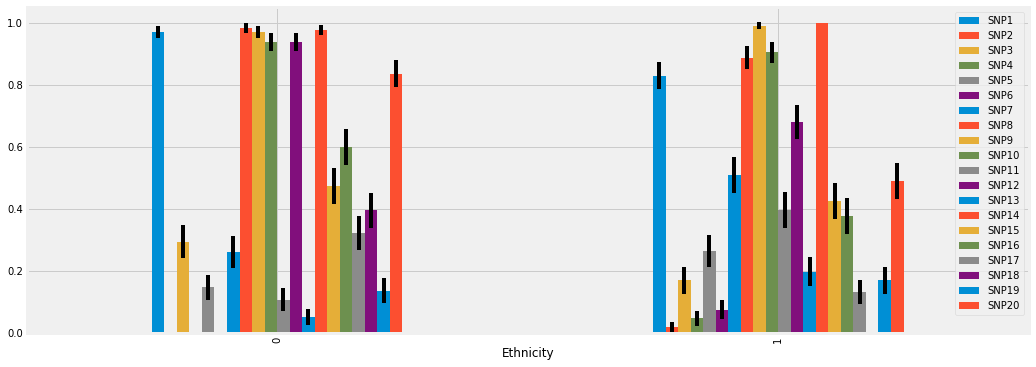

In [9]:
df.groupby('Ethnicity').mean().plot(kind='bar', yerr = 1.96*df.groupby('Ethnicity').std()/np.sqrt(len(df)))
plt.rcParams["figure.figsize"] = (20,10)

In [7]:
df1 = df.groupby('Ethnicity').mean() # This creates two rows, one for each value in the groupby clause. 
# Calling mean() on this groupby object calculates the mean for each numeric column. 
df1

,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10,SNP11,SNP12,SNP13,SNP14,SNP15,SNP16,SNP17,SNP18,SNP19,SNP20
Ethnicity,,,,,,,,,,,,,,,,,,,,
0,0.971751,0.000000,0.293785,0.00000,0.146893,0.000000,0.259887,0.983051,0.971751,0.937853,0.107345,0.937853,0.050847,0.977401,0.474576,0.598870,0.322034,0.39548,0.135593,0.836158
1,0.830189,0.018868,0.169811,0.04717,0.264151,0.075472,0.509434,0.886792,0.990566,0.905660,0.396226,0.679245,0.198113,1.000000,0.424528,0.377358,0.132075,0.00000,0.169811,0.490566


In [11]:
df1 = df1.diff() #this line gives the difference between each row of the df and the preceding one.
df1.reset_index() #this is needed to create an index based onthe group names (0,1)

,Ethnicity,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,...,SNP11,SNP12,SNP13,SNP14,SNP15,SNP16,SNP17,SNP18,SNP19,SNP20
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-0.141563,0.018868,-0.123974,0.04717,0.117258,0.075472,0.249547,-0.096258,0.018815,...,0.288882,-0.258608,0.147266,0.022599,-0.050048,-0.221512,-0.189958,-0.39548,0.034218,-0.345592


In [ ]:
# The point of doing this was to see which of the input features have comparatively more different mean 
# in two class groups. e.g. SNP20 (-0.345592)

In [12]:
df1.sort_values(by = 1, axis=1, ascending=False, inplace=True)

In [8]:
pd.crosstab(df.Ethnicity, df.SNP20) # this is a normal crosstab summary

SNP20,0,1
Ethnicity,,
0,29,148
1,54,52


In [9]:
pd.crosstab(df.Ethnicity, df.SNP20, normalize='index') # and this is a normalised one

SNP20,0,1
Ethnicity,,
0,0.163842,0.836158
1,0.509434,0.490566


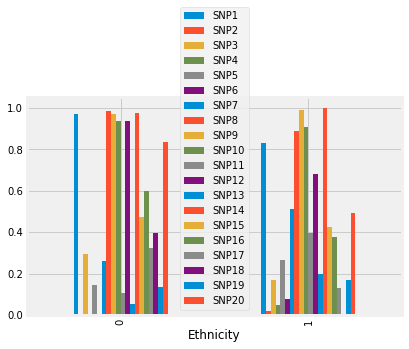

In [15]:
df.groupby('Ethnicity').mean().plot(kind='bar')

## Deciding relevance visually (and also by the diff())
We can notice that SNP18,SNP12,SNP20,SN16 are all more different in two classes.

In [17]:
df = df.assign(Prediction = "")

In [18]:
# You will get a SettingWithCopyWarning warning. You can ignore it. It's a warning, not an error.
for (row_index, row_data) in df.iterrows():
    if(df['SNP18'][row_index] == 1):
        df['Prediction'][row_index] = 0
    elif(df['SNP12'][row_index] == 0):
        df['Prediction'][row_index] = 1
    elif((df['SNP12'][row_index] == 1) & (df['SNP20'][row_index] == 0) & (df['SNP16'][row_index] == 0)):
        df['Prediction'][row_index] = 1
    elif((df['SNP12'][row_index] == 1) & (df['SNP20'][row_index] == 1)):
        df['Prediction'][row_index] = 0
    elif(np.random.rand() > 0.5):
        df['Prediction'][row_index] = 0
    else:
        df['Prediction'][row_index] = 1    

/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separat

## Evaluating model performance

In [22]:
pd.crosstab(df['Ethnicity'], df['Prediction']) #This is basically the Confusion Matrix. We get 42 FPs, 20 FNs as errors
# P = 157/199 = 0.79, R = 157/177 = 0.89, F1 = 1.4/1.68 = .83

Prediction,0,1
Ethnicity,,
0,157,20
1,42,64


## Part B- 
Correlation

In [26]:
# The O,1s are not really numbers. They are binary codes given to classes. Let's get rid of them

In [27]:
df["Ethnicity"]=df.apply(lambda row: "East Asian" if row["Ethnicity"] == 0 else "Mixed American", axis=1)

In [29]:
df.replace(0,"N", inplace = True)

In [31]:
df.replace(1,"Y", inplace = True)

In [32]:
df.head()

,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10,...,SNP13,SNP14,SNP15,SNP16,SNP17,SNP18,SNP19,SNP20,Ethnicity,Prediction
0,Y,N,N,N,N,N,N,Y,Y,Y,...,N,Y,N,N,Y,N,Y,Y,East Asian,N
1,Y,N,N,N,N,N,N,Y,Y,Y,...,N,Y,Y,Y,N,N,N,Y,East Asian,Y
2,Y,N,N,N,N,N,N,Y,Y,Y,...,N,Y,Y,Y,N,Y,N,Y,East Asian,N
3,Y,N,N,N,N,N,N,Y,Y,Y,...,N,Y,N,N,N,N,Y,Y,East Asian,N
4,Y,N,Y,N,Y,N,N,Y,Y,Y,...,N,Y,N,N,N,Y,N,N,East Asian,N


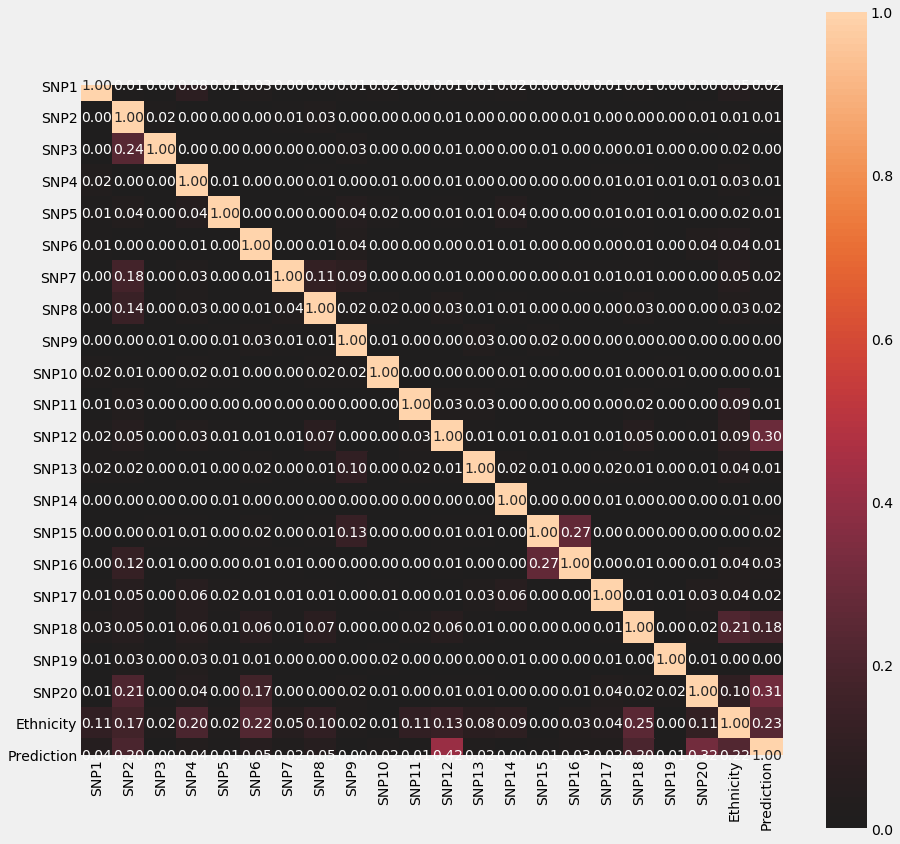

In [36]:
#heatmap I make use of an excellent library called dython
heat_map = associations(df, theil_u=True, figsize=(14, 14))

In [37]:
# Now we can see that the relevance is high for SNP18, SNP20, SNP12, SNP11,SNP7,SNP1,SNP6,SNP8 (in descending order)

In [38]:
# One surprising result is that SNP16, SNP15 are strongly correlated mutually (but not to ethnicity)

In [39]:
# So we write a programme to take all these features into consideration. 
# I chose the coefficients arbitrarily (the sqare root of correlation)

In [40]:
filename = "p_r_f1_threshold.csv"

In [56]:
with open(filename, 'w+', newline='') as csvfile:
    csvrow = csv.writer(csvfile, delimiter=',')
    csvrow.writerow(["Threshold","TP (testing for '0')","FN","FP","TN","Precision","Recall","F1"])
    for threshold in [.12,.25,.42]:
        for (row_index, row_data) in df.iterrows():
            predicted = 0
            if(df['SNP18'][row_index] == "N"):
                predicted = predicted + 0.128761783227184
            if(df['SNP20'][row_index] == "N"):
                predicted = predicted + 0.118075965756857
            if(df['SNP12'][row_index] == "N"):
                predicted = predicted + 0.113187926182593
            if(df['SNP11'][row_index] == "Y"):
                predicted = predicted + 0.113187926182593
            if(df['SNP7'][row_index] == "Y"):
                predicted = predicted + 0.0970578459776468
            if(df['SNP1'][row_index] == "N"):
                predicted = predicted + 0.0970578459776468
            if(df['SNP6'][row_index] == "Y"):
                predicted = predicted + 0.091048330077614
            if(df['SNP8'][row_index] == "N"):
                predicted = predicted + 0.0889549851963864
            if(df['SNP4'][row_index] == "Y"):
                predicted = predicted + 0.0800359501521536
            if(df['SNP5'][row_index] == "Y"):
                predicted = predicted + 0.0726314412693259
            if predicted > threshold:
                df['Prediction'][row_index] = "Mixed American"
            else:
                df['Prediction'][row_index] = "East Asian"
        predictions = pd.crosstab(df['Ethnicity'], df['Prediction'])
        tp = predictions.iloc[0,0]
        tn = predictions.iloc[1,1]
        fn = predictions.iloc[0,1]
        fp = predictions.iloc[1,0]
        p = round(tp/(tp+fp),2)
        r = round(tp/(tp+fn),2)
        f1 = round(2*p*r/(p+r),2)
        csvrow.writerow([threshold,tp,fn,fp,tn,p,r,f1])

In [62]:
f1_as_p_and_r_tradeoff = pd.read_csv("p_r_f1_threshold.csv")
f1_as_p_and_r_tradeoff # Notice how we can trade-off between FPs and FNs

,Threshold,TP (testing for '0'),FN,FP,TN,Precision,Recall,F1
0,0.12,60,117,0,106,1.00,0.34,0.51
1,0.25,157,20,24,82,0.87,0.89,0.88
2,0.42,177,0,62,44,0.74,1.00,0.85


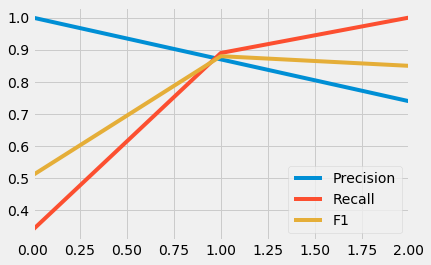

In [61]:
f1_as_p_and_r_tradeoff[["Precision","Recall","F1"]].plot()

## Part C-
Logistic Regression

In [68]:
# We will again need binary number coding
df = pd.read_csv('ancestry-train.txt', sep= " ", header=None)
df.columns = ['SNP1', 'SNP2', 'SNP3', 'SNP4','SNP5', 'SNP6', 'SNP7', 'SNP8', 'SNP9', 'SNP10', 'SNP11', 'SNP12', 'SNP13', 'SNP14', 'SNP15', 'SNP16', 'SNP17', 'SNP18', 'SNP19', 'SNP20', 'Ethnicity']

In [69]:
df['SNP20'] = df['SNP20'].apply(fix)


In [70]:
#manual train-test split using numpy's random.rand
mask = np.random.rand(len(df)) < 0.9
train = df[mask]
test = df[~mask]
print('Train Shape: {}\nTest Shape: {}'.format(train.shape, test.shape))

Train Shape: (248, 21)
Test Shape: (35, 21)


In [72]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [74]:
no_of_Mixed_Americans = train.Ethnicity.value_counts()[1]
print('There are {} Mixed American in the train data.'.format(no_of_Mixed_Americans))

There are 92 Mixed American in the train data.


In [75]:
#randomly selecting 92 random East Asians
east_Asians = train[train['Ethnicity'] == 0]
mixed_Americans = train[train['Ethnicity'] == 1]
selected = east_Asians.sample(no_of_Mixed_Americans)
selected.head()

,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10,...,SNP12,SNP13,SNP14,SNP15,SNP16,SNP17,SNP18,SNP19,SNP20,Ethnicity
157,0,0,0,0,1,0,1,1,1,0,...,1,0,1,1,1,1,0,1,1,0
163,1,0,0,0,0,0,0,1,1,1,...,1,0,1,0,0,1,0,1,1,0
31,1,0,0,0,0,0,1,1,1,1,...,1,0,1,1,1,0,0,0,1,0
175,1,0,0,0,0,0,1,1,1,1,...,1,0,1,0,0,0,1,0,1,0
39,1,0,0,0,0,0,0,1,1,1,...,1,0,1,0,0,0,1,0,1,0


In [76]:
#concatenating both into a subsample data set with equal class distribution
selected.reset_index(drop=True, inplace=True)
mixed_Americans.reset_index(drop=True, inplace=True)

In [78]:
subsample = pd.concat([selected, mixed_Americans])
len(subsample)

184

In [79]:
subsample = subsample.sample(frac=1).reset_index(drop=True)
subsample.head(10)

,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10,...,SNP12,SNP13,SNP14,SNP15,SNP16,SNP17,SNP18,SNP19,SNP20,Ethnicity
0,1,0,0,0,1,0,0,1,1,1,...,1,0,1,1,1,1,0,1,1,1
1,1,0,0,0,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,1,1,1,1,...,1,0,1,0,1,0,0,0,0,1
3,1,0,0,0,0,0,1,1,1,1,...,1,0,1,1,1,0,0,0,1,0
4,1,0,0,0,0,0,0,1,1,1,...,1,0,1,0,1,1,0,0,1,0
5,1,0,0,0,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
6,1,0,1,0,0,0,0,1,1,1,...,1,0,1,0,1,0,1,0,0,0
7,1,0,1,0,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,1,1,1,...,1,0,1,0,1,0,0,0,1,0
9,1,0,0,0,0,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,1


In [80]:
# Dimensionality Reduction

In [81]:
from sklearn.manifold import TSNE

In [82]:
X = subsample.drop('Ethnicity', axis=1)

In [83]:
y = subsample['Ethnicity']

In [84]:
#t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

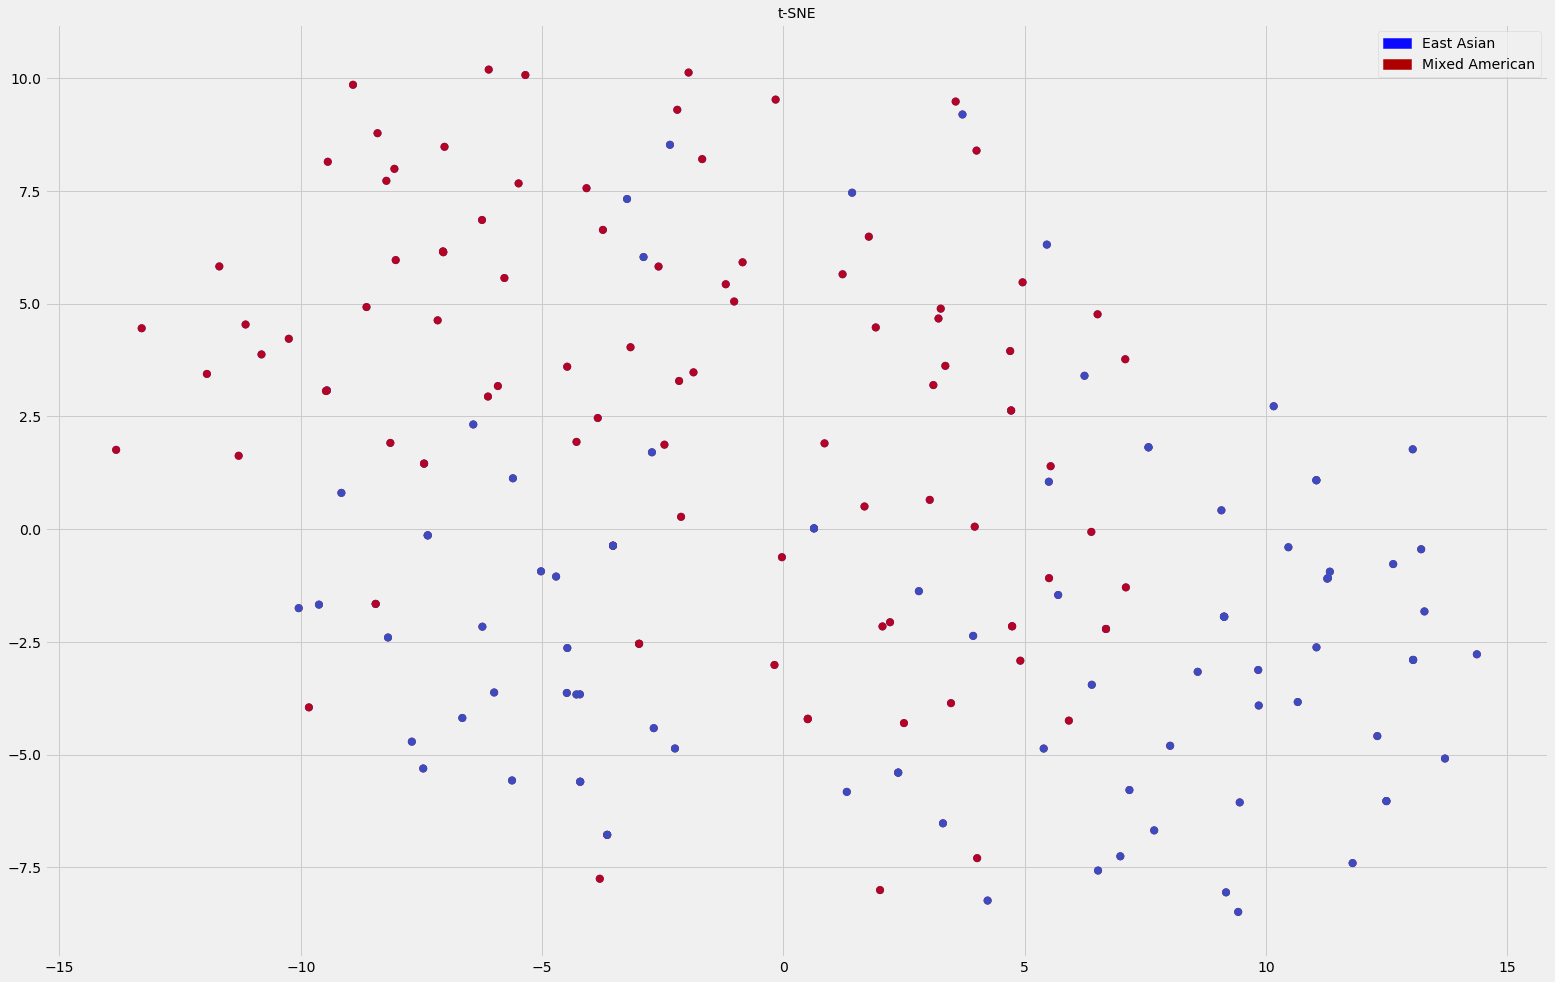

In [85]:
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='East Asian')
red_patch = mpatches.Patch(color='#AF0000', label='Mixed American')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='East Asian', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Mixed American', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42)

In [105]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [106]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape, X_validation.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape, y_validation.shape)

X_shapes:
 X_train: X_validation:
 (138, 20) (46, 20) 

Y_shapes:
 Y_train: Y_validation:
 (138,) (46,)


In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [108]:
kfold = KFold(n_splits=10, random_state=42)
cv_results = cross_val_score(LogisticRegression(), X_train, y_train, cv=kfold, scoring='roc_auc')
name = "LR"
msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
print(msg)

LR: 0.918526 (0.066229)


/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

In [109]:
logisticRegr = LogisticRegression()
logreg = logisticRegr.fit(X_train, y_train) #fitting the model with data

/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [110]:
np.exp(logreg.coef_)

array([[0.65668136, 1.06731919, 0.62310402, 1.42274188, 1.41752136,
        2.58882795, 1.78682975, 0.52274819, 2.4449077 , 1.11572129,
        6.00477162, 0.42101443, 2.50014399, 2.49434276, 1.49458752,
        0.4218271 , 0.43176367, 0.18404541, 1.57657106, 0.23491079]])

In [111]:
y_pred = logreg.predict(X_test)

In [112]:
#evaluating
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix

array([[18,  6],
       [ 5, 17]])

In [102]:
# P = 18/23 = 0.78, R = 0.75, F1= 1.17/1.53 = 0.76

## Comparison
Though we achieved better F1 by the first two methods, they involved human intervention and modeling. The third one was fully automatic.

In [159]:
# As an aside, I will try to repeat part C with only the most relevant features

In [199]:
df = pd.read_csv('ancestry-train.txt', sep= " ", header=None)
df.columns = ['SNP1', 'SNP2', 'SNP3', 'SNP4','SNP5', 'SNP6', 'SNP7', 'SNP8', 'SNP9', 'SNP10', 'SNP11', 'SNP12', 'SNP13', 'SNP14', 'SNP15', 'SNP16', 'SNP17', 'SNP18', 'SNP19', 'SNP20', 'Ethnicity']
# df = df[["SNP18","SNP20","SNP12","SNP7","SNP1","SNP6","SNP8","SNP4","SNP5","Ethnicity"]]
df = df[["SNP18","SNP20","SNP12","SNP7","Ethnicity"]]
df['SNP20'] = df['SNP20'].apply(fix)
df.shape

(283, 5)

In [200]:
east_Asians = df[df['Ethnicity'] == 0]
mixed_Americans = df[df['Ethnicity'] == 1]
selected = east_Asians.sample(no_of_Mixed_Americans)
selected.head()

,SNP18,SNP20,SNP12,SNP7,Ethnicity
33,0,1,1,1,0
16,0,1,1,1,0
122,0,1,0,0,0
164,1,1,1,0,0
171,1,1,1,0,0


In [201]:
subsample = pd.concat([selected, mixed_Americans])
len(subsample)

198

In [202]:
X = subsample.drop('Ethnicity', axis=1)
y = subsample['Ethnicity']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [205]:
logisticRegr = LogisticRegression()
logreg = logisticRegr.fit(X_train, y_train) #fitting the model with data

/Users/sanjaysingh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [206]:
y_pred = logreg.predict(X_test)

In [207]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cnf_matrix

array([[14,  4],
       [ 4, 18]])

In [208]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8
Precision: 0.8181818181818182
Recall: 0.8181818181818182


In [ ]:
# Better than before